# Understanding and Mitigating Overfitting with L2 Regularization

* This notebook demonstrates the crucial machine learning concept of **overfitting** and how **L2 Regularization** can effectively combat it.
* We start by building a simple neural network that readily overfits a synthetic dataset.
* Then, we implement L2 regularization from scratch within the Keras framework and apply it to the same model, clearly showcasing its ability to improve the model's generalization capabilities through visual analysis of loss curves, decision boundaries, and weight distributions.


In [7]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=0.2,random_state=4)

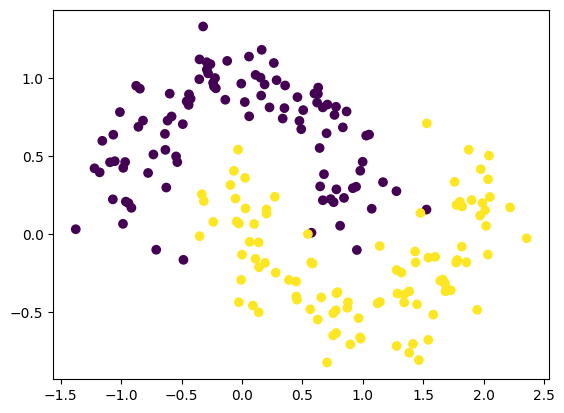

In [8]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [9]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1 = Sequential()

model1.add(Dense(64,input_dim=2, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(1,activation='sigmoid'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model1.fit(X, y, epochs=2000, validation_split = 0.2,verbose=0)

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


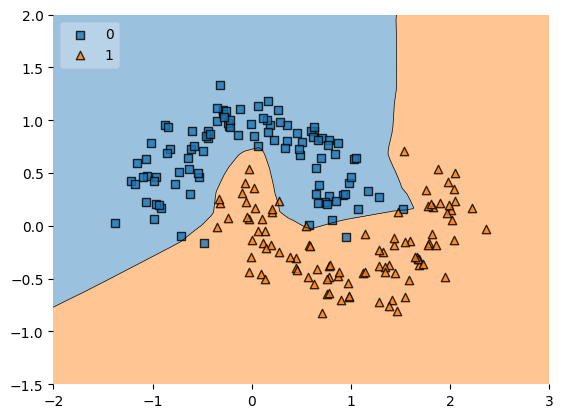

In [11]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y.astype('int'), clf=model1, legend=2)
plt.xlim(-2,3)
plt.ylim(-1.5,2)
plt.show()

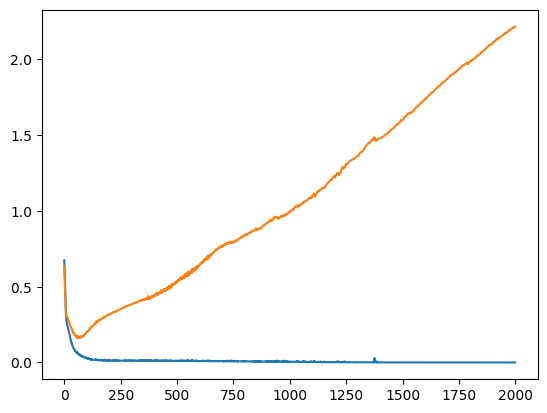

In [12]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

### Observing Overfitting from the Loss

Looking at the **Loss Curves** graph, we can clearly identify signs of overfitting:

* **Training Loss (Blue Line):** This line consistently decreases and approaches zero, indicating that the model is learning to predict the training data with very high accuracy.
* **Validation Loss (Orange Line):** Initially, the validation loss also decreases, but after a certain point (around epoch 100-200 in the example), it starts to increase significantly, while the training loss continues to drop. This divergence is the hallmark of overfitting: the model is becoming too specialized to the training data, learning its noise and specific patterns, and thus performing poorly on unseen validation data.


### What is Regularization?

* **Regularization** is a set of techniques used in machine learning to prevent **overfitting** and improve the generalization ability of models.
* Overfitting occurs when a model learns the training data too well, including noise and specific patterns that don't apply to new, unseen data.
* Regularization achieves its goal by adding a penalty to the model's loss function, discouraging it from becoming too complex.

We are implementing **L2 Regularization**, also known as **Ridge Regularization** or **Weight Decay**.

**Why L2 Regularization?**

* L2 regularization adds a penalty proportional to the **square of the magnitude of the model's weights**.
* Its primary effects are:
    * **Discourages Large Weights:** By penalizing large weights, L2 regularization forces the model to use all features more evenly, rather than relying heavily on a few features with very large weights. This leads to simpler and smoother models.
    * **Prevents Overfitting:** Smaller weights result in a less complex model that is less sensitive to small fluctuations or noise in the training data, making it generalize better to unseen data.
    * **Computational Efficiency:** It's differentiable, making it compatible with gradient-based optimization methods.


In [13]:
import tensorflow as tf
class CustomL2(tf.keras.regularizers.Regularizer):
    def __init__(self, l2_strength):
        self.l2_strength = l2_strength
    def __call__(self, weights):
        return self.l2_strength * tf.reduce_sum(tf.square(weights))
    def get_config(self):
        return {'l2_strength': self.l2_strength}

### Implementing L2 Regularization from Scratch (Custom Keras Regularization)

To implement L2 regularization from scratch within Keras, we define a custom `tf.keras.regularizers.Regularizer` subclass. This allows us to inject our specific penalty calculation directly into Keras's optimization process.

**Algorithm:**

**Define `CustomL2` Class:**
* **Inheritance:** The `CustomL2` class inherits from `tf.keras.regularizers.Regularizer`, conforming to Keras's API for custom regularizers.
* **Initialization (`__init__`)**: The constructor `__init__(self, l2_strength)` takes a hyperparameter `l2_strength` (denoted as $\lambda$), which quantifies the regularization intensity. This $\lambda$ value will scalar-multiply the sum of squared weights.
* **Penalty Calculation (`__call__`)**: The `__call__(self, weights)` method is the core. When invoked by Keras, it computes the L2 penalty for a given tensor of `weights`:
    $$ \text{Penalty} = \lambda \sum_{i} W_i^2 $$
    This is implemented as `self.l2_strength * tf.reduce_sum(tf.square(weights))`. Keras then adds this calculated penalty to the layer's contribution to the total loss.
* **Serialization (`get_config`)**: The `get_config(self)` method is essential for model serialization, allowing Keras to reconstruct the regularizer by returning a dictionary containing its `l2_strength`.

In [14]:
l2_lambda_value = 0.001
model2 = Sequential()

model2.add(Dense(64, input_dim=2, activation="relu", kernel_regularizer=CustomL2(l2_lambda_value)))
model2.add(Dense(64, activation="relu", kernel_regularizer=CustomL2(l2_lambda_value)))
model2.add(Dense(64, activation="relu", kernel_regularizer=CustomL2(l2_lambda_value)))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(X, y, epochs=2000, validation_split = 0.2,verbose=0)

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


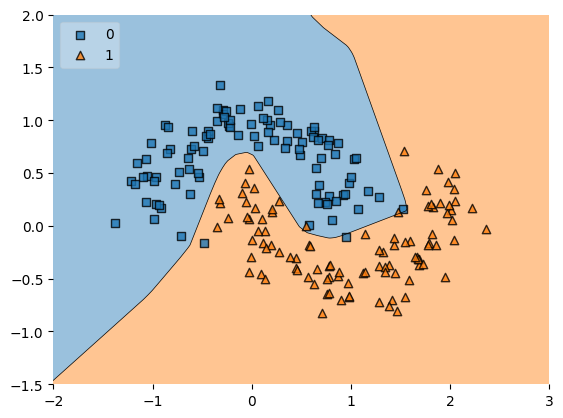

In [16]:
plot_decision_regions(X, y.astype('int'), clf=model2, legend=2)
plt.xlim(-2,3)
plt.ylim(-1.5,2)
plt.show()

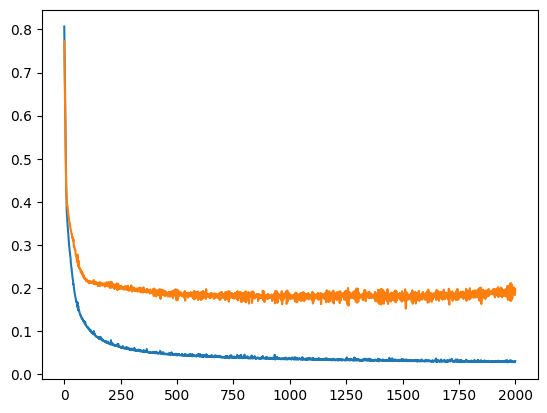

In [17]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

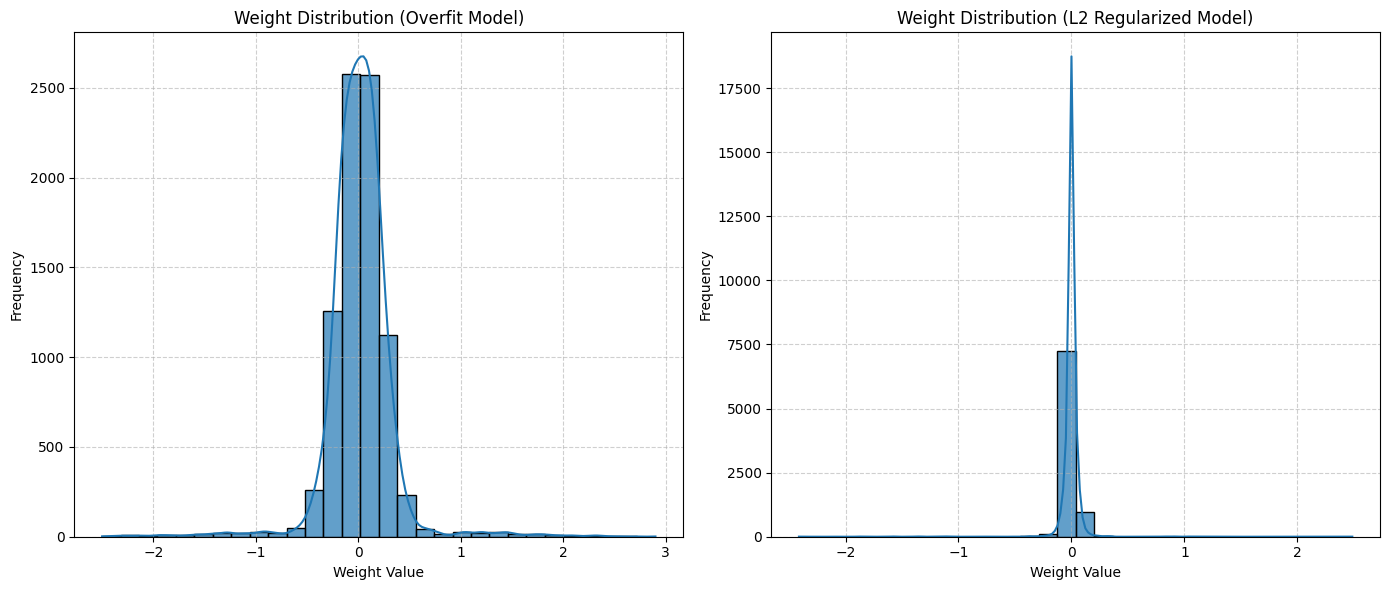

In [23]:
def plot_keras_weight_histograms(model, title, ax):
    all_weights = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense) and len(layer.get_weights()) > 0:
            all_weights.extend(layer.get_weights()[0].flatten())

    if all_weights:
        sns.histplot(all_weights, bins=30, kde=True, ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.6)
    else:
        ax.text(0.5, 0.5, 'No weights found', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_keras_weight_histograms(model1, 'Weight Distribution (Overfit Model)', axes[0])
plot_keras_weight_histograms(model2, 'Weight Distribution (L2 Regularized Model)', axes[1])
plt.tight_layout()
plt.show()

### L2 Regularization Keeps Weights Close to Zero

The **Weight Distribution** graphs, provide direct visual evidence of L2 regularization's effect:

* **Weight Distribution (Overfit Model) - Left Graph:** You'll observe that the weights are more spread out, and their magnitudes can be relatively larger (further away from zero). This indicates that the non-regularized model is free to assign high importance (large weight values) to specific features or patterns, even if they are just noise in the training data. This leads to a complex model that overfits.

* **Weight Distribution (L2 Regularized Model) - Right Graph:** The weights for the L2 regularized model are highly **concentrated around zero**. The histogram is much narrower and taller, demonstrating that L2 regularization successfully penalized large weights, pushing most of them closer to zero. This "decaying" effect forces the model to rely on a larger number of features more uniformly, rather than heavily weighting a few. The result is a simpler, smoother model that generalizes better to unseen data, as evidenced by its improved validation performance.



### Advantages and Disadvantages of L2 Regularization

L2 Regularization is a powerful technique for controlling model complexity and improving generalization. However, like any method, it comes with its own set of trade-offs.

**Advantages of L2 Regularization:**

* **Prevents Overfitting:** This is its primary benefit. By penalizing large weights, it discourages the model from becoming overly complex and fitting noise in the training data, leading to better performance on unseen data.
* **Encourages Smaller, Distributed Weights (Weight Decay):** L2 regularization pushes weight values closer to zero (but rarely exactly zero). This means the model is encouraged to use all features, but to assign a more balanced, less extreme importance to each, resulting in smoother decision boundaries.
* **Improves Model Generalization:** A model with smaller, more evenly distributed weights is generally less sensitive to individual data points or small variations, making it more robust and effective on new, real-world data.
* **Always Differentiable:** The squared term in the L2 penalty is continuously differentiable, which makes it perfectly compatible with gradient-based optimization algorithms (like those used to train neural networks).

**Disadvantages of L2 Regularization:**

* **Does Not Perform Feature Selection:** Since L2 regularization shrinks weights towards zero but doesn't force them *to* zero, it doesn't inherently perform automatic feature selection. All features will still have some non-zero weight, even if their contribution is minimal. If sparsity (identifying and discarding irrelevant features) is desired, L1 regularization might be a more suitable choice.
* **Hyperparameter Tuning Required:** The regularization strength ($\lambda$) is a crucial hyperparameter that needs careful tuning (e.g., via cross-validation). An inappropriate $\lambda$ value can either fail to prevent overfitting (if too small) or lead to underfitting (if too large), adding an extra step to the model development process.
* **Slight Increase in Training Time:** While generally efficient, the additional calculation of the regularization term and its gradient during each training iteration slightly increases the overall computational cost compared to an unregularized model.







#### When to Use L2 Regularization:

* **To Prevent Overfitting:** It's your go-to when your model performs well on training data but poorly on unseen data.
* **When Most Features Are Relevant:** Use it when you believe most of your features contribute some useful information; L2 distributes importance across them.
* **For Smoother Decision Boundaries:** It leads to smaller coefficients and less erratic decision boundaries, making your model less sensitive to minor input fluctuations.
* **With Gradient-Based Optimization:** L2's differentiability makes it perfectly compatible with algorithms like Stochastic Gradient Descent (SGD).



#### When Not to Use L2 Regularization (or Consider Alternatives):

* **For Feature Selection/Sparsity:** If you need to automatically identify and remove irrelevant features (set weights to zero), **L1 Regularization (Lasso)** is a better choice.
* **When Underfitting is a Risk:** If you have very limited data and your model is already too simple, adding L2 might exacerbate underfitting.
* **When Training Time is Absolutely Paramount (and Overfitting Isn't an Issue):** The computational overhead is minor, but if every millisecond counts and overfitting isn't a problem, you might omit it.
* **When Selecting One Feature from Correlated Groups:** L2 shrinks correlated features equally. For selecting a single representative, L1 might be more effective.
